# ClinicalTrials.gov TF-IDF  Analysis by Maria-Elena Froese

## Introduction

### ClinicalTrials.gov
ClinicalTrials.gov is the world's largest repository of clinical-trials protocols. It was established by the National Institutes of Health (NIH) to gather all clinical trials conducted under the US Food and Drug Administration FDA regulations. Clinical Trials.gov main goal is to provide accurate information on clinical trials with human subjects.  

ClinicalTrials.gov stores trials in semi-structured format. That is, the entry for each trial consists of a set of fields such as title, eligibility criteria, outcomes, or start date. Most of the data components are filled out with text-based description, while a few are tagged with specific medical terms from the Unified Language System (UMLS).

### Data dictionary
- **Rank**: Trial identifier, sequential number
- **Title**: The title of the clinical study, corresponding to the title of the protocol.
- **Status**: The recruitment status for the clinical study (Not yet recruiting/Recruiting/Enrolling by invitation/Active/Completed/Suspended/Terminated/Withdrawn)
- **Study Results**: Results of the study
- **Conditions**: The name(s) of the disease(s) or condition(s) studied in the clinical study, or the focus of the clinical study. 
- **Interventions**: A description of each arm of the clinical trial that indicates its role in the clinical trial 
- **Study Type**: The nature of the investigation (Interventional/Observational/Expanded Access).
- **Study Designs**: A description of the manner in which the clinical trial will be conducted
- **URL**:ClinicalTrials.gov URL for the trial

### Scope
In this analysis, I am using a set of trials related to the treatment of COVID-19. I am interested in finding out what are the most frequent drugs being tested to treat COVID-19 these results could be used by medical researchers, Clinical Trials Designers, Systematic Reviewers and Clinical care staff looking for clinical trial information. 

I am approaching this problem with Natural Language Processing techniques NPL, in particular, I am applying a Term Frequency - Inverse Document Frequency (TF-IDF) analysis to the Interventions in the trials to determine the frequency value of the terms. TF-IDF is used to quantify the importance of each word in a set of documents. This technique helps us alleviate the issue that a signle word can be used many times in the same document.

Doing NLP is not a trivial task and can be aggravated by the fact that the vocabulary researchers use to describe Interventions is quite technical and there are many synonyms. To make things worse, some reseachers encode their treatments (e.g. gx-i7, resp301) making difficult to know that are the actual substances being tested.   


### Setup

Defining the libraries that will be used in the analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import nltk
import string
import re

from nltk.corpus import stopwords
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

# scikitplot to directly plot our results
#from mlxtend.plotting import plot_decision_regions
#from mlxtend.plotting import category_scatter


Uploading the data and start the inspection to familiarize myself with the COVID-19 trials

In [2]:
studies = pd.read_csv('CTSearchResults.csv')

In [3]:
studies.shape

(7071, 10)

In [4]:
studies.head(30) 

,Rank,Title,Status,Study Results,Conditions,Interventions,Outcome Measures,Study Type,Study Designs,URL
0,1,Duvelisib to Combat COVID-19,Recruiting,No Results Available,COVID-19,Drug: Duvelisib|Procedure: Peripheral blood dr...,Overall survival|Length of hospital stay|Lengt...,Interventional,Allocation: Randomized|Intervention Model: Sin...,https://ClinicalTrials.gov/show/NCT04372602
1,2,Relationship Between CT- Value With Prognosis ...,Recruiting,No Results Available,COVID-19,Diagnostic Test: Cycle threshold,prognosis,Observational,Observational Model: Cohort|Time Perspective: ...,https://ClinicalTrials.gov/show/NCT04902157
2,3,Observational Cohort of COVID-19 Patients at R...,Recruiting,No Results Available,COVID-19,NaN,"clinical, biological and radiological characte...",Observational,Observational Model: Cohort|Time Perspective: ...,https://ClinicalTrials.gov/show/NCT04364698
3,4,COVID-19 Surveillance Based on Smart Wearable ...,Not yet recruiting,No Results Available,COVID-19,NaN,Deterioration of the condition|Mortality|The i...,Observational,Observational Model: Cohort|Time Perspective: ...,https://ClinicalTrials.gov/show/NCT04459637
4,5,A Phase 2 Trial of Infliximab in Coronavirus D...,Completed,No Results Available,COVID-19,Drug: Infliximab,Time to improvement in oxygenation|28-day mort...,Interventional,Allocation: N/A|Intervention Model: Single Gro...,https://ClinicalTrials.gov/show/NCT04425538
5,6,Pulmonary Rehabilitation Post-COVID-19,Not yet recruiting,No Results Available,COVID-19,Other: Exercise program (virtual/remote),Change in lung capacity|Change in dyspnea|Chan...,Interventional,Allocation: Randomized|Intervention Model: Par...,https://ClinicalTrials.gov/show/NCT05003271
6,7,Safety & Effectiveness Evaluation of Seraph 10...,Recruiting,No Results Available,COVID-19,Device: Seraph 100,Change in Organ failure|Change in Organ Failur...,Interventional,Allocation: Randomized|Intervention Model: Par...,https://ClinicalTrials.gov/show/NCT04547257
7,8,Safety and Efficacy of Tramadol in COVID-19 Eg...,Not yet recruiting,No Results Available,COVID-19,Drug: Tramadol|Other: Standard care delivered ...,Number of COVID-19 PCR negative cases,Interventional,Allocation: Randomized|Intervention Model: Par...,https://ClinicalTrials.gov/show/NCT04454307
8,9,Safety and Efficacy of C21 in Subjects With CO...,Completed,Has Results,COVID-19,Drug: C21|Drug: Placebo,Change From Baseline in C-reactive Protein (CR...,Interventional,Allocation: Randomized|Intervention Model: Par...,https://ClinicalTrials.gov/show/NCT04452435
9,10,Application of Desferal to Treat COVID-19,Recruiting,No Results Available,COVID-19,Drug: Deferoxamine,Mortality rate|change in patients clinical man...,Interventional,Allocation: Randomized|Intervention Model: Par...,https://ClinicalTrials.gov/show/NCT04333550


## Cleaning the data focusing on "Interventions" column

### Remove trials to narrow the scope to trials testing drugs. 

Removing the URL column that seems irrelevant to this analysis

In [5]:
studies.drop('URL', axis=1, inplace=True) 
studies.shape

(7071, 9)

Removing non-interventional studies, as I am not interested in observational or behavioural trials

In [6]:
studies.drop(studies[studies['Study Type']!="Interventional"].index, inplace=True)
studies.shape

(3975, 9)

There are many interventional trials where drugs where NOT the primary ontervention to be tested 

In [7]:
studies[~studies['Interventions'].str.startswith('Drug:')]

,Rank,Title,Status,Study Results,Conditions,Interventions,Outcome Measures,Study Type,Study Designs
5,6,Pulmonary Rehabilitation Post-COVID-19,Not yet recruiting,No Results Available,COVID-19,Other: Exercise program (virtual/remote),Change in lung capacity|Change in dyspnea|Chan...,Interventional,Allocation: Randomized|Intervention Model: Par...
6,7,Safety & Effectiveness Evaluation of Seraph 10...,Recruiting,No Results Available,COVID-19,Device: Seraph 100,Change in Organ failure|Change in Organ Failur...,Interventional,Allocation: Randomized|Intervention Model: Par...
16,17,Randomized Study to Evaluate Intranasal Dose o...,Not yet recruiting,No Results Available,COVID-19,Biological: COVI-DROPS|Drug: Placebo,Proportion of subjects who have a COVID-19-rel...,Interventional,Allocation: Randomized|Intervention Model: Par...
17,18,A Study Evaluating the Efficacy and Safety of ...,"Active, not recruiting",No Results Available,COVID-19,Biological: anti-SARS-CoV-2 convalescent plasma,Overall Mortality within 60 days|Length of ICU...,Interventional,Allocation: Non-Randomized|Intervention Model:...
20,21,AZD1222 Vaccine for the Prevention of COVID-19,Withdrawn,No Results Available,COVID-19,Biological: AZD1222,Incidence of SAEs following the first vaccinat...,Interventional,Allocation: N/A|Intervention Model: Single Gro...
...,...,...,...,...,...,...,...,...,...
7063,7064,DiaBetter Together for Young Adults With Type ...,Enrolling by invitation,No Results Available,Type 1 Diabetes,Behavioral: DiaBetter Together|Behavioral: Pee...,Glycemic Control (HbA1c)|Time to First Adult C...,Interventional,Allocation: Randomized|Intervention Model: Par...
7064,7065,Healthcare Provider Human Papillomavirus Educa...,Not yet recruiting,No Results Available,"Health Personnel Attitude|Health Knowledge, At...",Behavioral: Tailored HPV Education and Profess...,Between-group changes in proportions from base...,Interventional,Allocation: Randomized|Intervention Model: Par...
7065,7066,Feasibility of Remote Home Support Coaches (SO...,Not yet recruiting,No Results Available,Malnutrition|Isolation|Depression|Anxiety|Sede...,Behavioral: Telephone-based coaching,Physical Activity - Self-report survey to meas...,Interventional,Allocation: N/A|Intervention Model: Single Gro...
7067,7068,Mesenchymal Stem Cells for the Treatment of Va...,Recruiting,No Results Available,Autoimmune Diseases|Cardiovascular Disorders|D...,Biological: PrimePro™/ PrimeMSK™,Assessment of quality of life (QOL) via 36-Ite...,Interventional,Allocation: Non-Randomized|Intervention Model:...


Removing trials that are not centered on a drug testing

In [8]:
studies.drop(studies[~studies['Interventions'].str.startswith('Drug:')].index, inplace=True)

In [9]:
studies['Interventions']

0       Drug: Duvelisib|Procedure: Peripheral blood dr...
4                                        Drug: Infliximab
7       Drug: Tramadol|Other: Standard care delivered ...
8                                 Drug: C21|Drug: Placebo
9                                      Drug: Deferoxamine
                              ...                        
7056                                  Drug: Crizanlizumab
7058                     Drug: Azithromycin|Drug: Placebo
7059                     Drug: Pitavastatin|Drug: Placebo
7060    Drug: Lopinavir/Ritonavir 200 mg/50 mg Film Ta...
7068                   Drug: Echinaforce Chewable tablets
Name: Interventions, Length: 1685, dtype: object

In [10]:
studies.shape

(1685, 9)

### Preprocessing text

Converting the text to be analysized into lower case

In [11]:
studies['Interventions'] = studies['Interventions'].apply(str.lower)
studies['Interventions'] = studies['Interventions'].map(str.lower)
studies.shape

(1685, 9)

Standarizing the wording for important keywords such as covid-19, covid 19 and covid19
sars-cov2, sars-cov 2, sars-cov-2 

In [12]:
def standarize_entry(entry):

    if 'covid 19' in entry:
        clean_entry = entry.replace('covid 19', 'covid19')
    if 'covid19' in entry:
        clean_entry = entry.replace('covid-19', 'covid19')
    if 'sars-cov 2' in entry:
        clean_entry = entry.replace('sars-cov 2', 'sarscov2')
    if 'sars-cov2' in entry:
        clean_entry = entry.replace('sars-cov-2', 'sarscov2')
    else:
        clean_entry = entry
    return clean_entry


studies['Interventions'] = studies['Interventions'].apply(standarize_entry)

Removing stopwords in the English language as they provide not value to the analysis

In [13]:
stop = stopwords.words('english') #defining stopwords
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Excluding stopwords

In [14]:
studies['Interventions'] = studies['Interventions'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
studies['Interventions']

0       drug: duvelisib|procedure: peripheral blood dr...
4                                        drug: infliximab
7       drug: tramadol|other: standard care delivered ...
8                                 drug: c21|drug: placebo
9                                      drug: deferoxamine
                              ...                        
7056                                  drug: crizanlizumab
7058                     drug: azithromycin|drug: placebo
7059                     drug: pitavastatin|drug: placebo
7060    drug: lopinavir/ritonavir 200 mg/50 mg film ta...
7068                   drug: echinaforce chewable tablets
Name: Interventions, Length: 1685, dtype: object

Removing numbers as they do not provide high value to the analysis of Interventions

In [15]:
def remove_numbers(text):
    text = re.sub('[^\w]\d+\s*%?', '', text)
    return text

studies['Interventions'] = studies['Interventions'].apply(remove_numbers)
studies['Interventions']

0       drug: duvelisib|procedure: peripheral blood dr...
4                                        drug: infliximab
7       drug: tramadol|other: standard care delivered ...
8                                 drug: c21|drug: placebo
9                                      drug: deferoxamine
                              ...                        
7056                                  drug: crizanlizumab
7058                     drug: azithromycin|drug: placebo
7059                     drug: pitavastatin|drug: placebo
7060    drug: lopinavir/ritonavirmgmg film tablet|drug...
7068                   drug: echinaforce chewable tablets
Name: Interventions, Length: 1685, dtype: object

Removing units of measure

In [16]:
def remove_units(text):
    text = re.sub('mg|mcg|mgday|mgdaydrug|ml|kg|mm|gr', '', text)
    return text

studies['Interventions'] = studies['Interventions'].apply(remove_units)
studies['Interventions']

0       drug: duvelisib|procedure: peripheral blood dr...
4                                        drug: infliximab
7       drug: tramadol|other: standard care delivered ...
8                                 drug: c21|drug: placebo
9                                      drug: deferoxamine
                              ...                        
7056                                  drug: crizanlizumab
7058                     drug: azithromycin|drug: placebo
7059                     drug: pitavastatin|drug: placebo
7060    drug: lopinavir/ritonavir film tablet|drug: lo...
7068                   drug: echinaforce chewable tablets
Name: Interventions, Length: 1685, dtype: object

Ensuring the delimiters symbols are substituted by spaces

In [17]:
def remove_delimiters(text):
    text = re.sub('\|', ' ', text)
    text = re.sub('\/', ' ', text)
    text = re.sub('\_', '-', text)
    text = re.sub('\--', '-', text)
    
    return text

studies['Interventions'] = studies['Interventions'].apply(remove_delimiters)
studies['Interventions']

0       drug: duvelisib procedure: peripheral blood dr...
4                                        drug: infliximab
7       drug: tramadol other: standard care delivered ...
8                                 drug: c21 drug: placebo
9                                      drug: deferoxamine
                              ...                        
7056                                  drug: crizanlizumab
7058                     drug: azithromycin drug: placebo
7059                     drug: pitavastatin drug: placebo
7060    drug: lopinavir ritonavir film tablet drug: lo...
7068                   drug: echinaforce chewable tablets
Name: Interventions, Length: 1685, dtype: object

Removing the strings *drug:*, *procedure:*, and *other:* 

In [18]:
def remove_numbers(text):
    text = re.sub('drug:', '', text)
    text = re.sub('procedure:', '', text)
    text = re.sub('other:', '', text)

    return text

studies['Interventions'] = studies['Interventions'].apply(remove_numbers)
studies['Interventions'] 

0               duvelisib  peripheral blood draw  placebo
4                                              infliximab
7        tramadol  standard care delivered isolation h...
8                                            c21  placebo
9                                            deferoxamine
                              ...                        
7056                                        crizanlizumab
7058                                azithromycin  placebo
7059                                pitavastatin  placebo
7060     lopinavir ritonavir film tablet  lopinavir ri...
7068                         echinaforce chewable tablets
Name: Interventions, Length: 1685, dtype: object

Removing puntuation

In [19]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
import string

def remove_punctuations(text):
    for punctuation in string.punctuation:
        if (punctuation != '-'):
            text = text.replace(punctuation, '')
    return text

studies['Interventions'] = studies['Interventions'].apply(remove_punctuations)
studies['Interventions']

0               duvelisib  peripheral blood draw  placebo
4                                              infliximab
7        tramadol  standard care delivered isolation h...
8                                            c21  placebo
9                                            deferoxamine
                              ...                        
7056                                        crizanlizumab
7058                                azithromycin  placebo
7059                                pitavastatin  placebo
7060     lopinavir ritonavir film tablet  lopinavir ri...
7068                         echinaforce chewable tablets
Name: Interventions, Length: 1685, dtype: object

Removing single charaters

In [21]:

studies['Interventions'] = studies['Interventions'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))
studies['Interventions']

0                 duvelisib peripheral blood draw placebo
4                                              infliximab
7       tramadol standard care delivered isolation hos...
8                                             c21 placebo
9                                            deferoxamine
                              ...                        
7056                                        crizanlizumab
7058                                 azithromycin placebo
7059                                 pitavastatin placebo
7060    lopinavir ritonavir film tablet lopinavir rito...
7068                         echinaforce chewable tablets
Name: Interventions, Length: 1685, dtype: object

### Stemming

This is one of the most important part of the preprocessing. **Stemming** reduces words to their stem.
For example, playing and played are the same type of words that basically indicate an action play. 

In [22]:
import string
#Stemming
stemmer = PorterStemmer()

studies['Interventions'] = studies['Interventions'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x.split() if True]))
studies['Interventions']

0                   duvelisib peripher blood draw placebo
4                                              infliximab
7                tramadol standard care deliv isol hospit
8                                             c21 placebo
9                                             deferoxamin
                              ...                        
7056                                        crizanlizumab
7058                                 azithromycin placebo
7059                                 pitavastatin placebo
7060    lopinavir ritonavir film tablet lopinavir rito...
7068                            echinaforc chewabl tablet
Name: Interventions, Length: 1685, dtype: object

Tokenize entries 

In [23]:
import string
import nltk

def tokenize_entry(entry):
    tokenized = nltk.word_tokenize(entry)
    return tokenized


studies['Interventions'] = studies['Interventions'].apply(tokenize_entry)
studies['Interventions']

0             [duvelisib, peripher, blood, draw, placebo]
4                                            [infliximab]
7         [tramadol, standard, care, deliv, isol, hospit]
8                                          [c21, placebo]
9                                           [deferoxamin]
                              ...                        
7056                                      [crizanlizumab]
7058                              [azithromycin, placebo]
7059                              [pitavastatin, placebo]
7060    [lopinavir, ritonavir, film, tablet, lopinavir...
7068                        [echinaforc, chewabl, tablet]
Name: Interventions, Length: 1685, dtype: object

In [24]:
#Part-of-Speech Tagging
import string


def pos_entry(entry):
    tagged = nltk.pos_tag(entry)
    return tagged


studies['Interventions'] = studies['Interventions'].apply(pos_entry)
studies['Interventions']

0       [(duvelisib, NN), (peripher, CC), (blood, NN),...
4                                      [(infliximab, NN)]
7       [(tramadol, RB), (standard, JJ), (care, NN), (...
8                              [(c21, NN), (placebo, NN)]
9                                     [(deferoxamin, NN)]
                              ...                        
7056                                [(crizanlizumab, NN)]
7058                  [(azithromycin, NN), (placebo, NN)]
7059                  [(pitavastatin, NN), (placebo, NN)]
7060    [(lopinavir, NN), (ritonavir, NN), (film, NN),...
7068      [(echinaforc, NN), (chewabl, NN), (tablet, NN)]
Name: Interventions, Length: 1685, dtype: object

In [25]:
#Convert tags into WORDNET tags

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  #default to noun

### Lemmatisation

Lemmatisation is a way to reduce the word to the root synonym of a word. Unlike Stemming, Lemmatisation makes sure that the reduced word is again a dictionary word (word present in the same language). WordNetLemmatizer can be used to lemmatize any word.

In [26]:
#Lemmatize entries
from nltk.stem import WordNetLemmatizer

l = WordNetLemmatizer()

#Note that l.lemmatize(tag[0], get_wordnet_pos(tag[1]) is the same than l.lemmatize(*tagged))
def lemmatize_entry(entry):
    lemmatized = []
    for tag in entry:
        tagged = (tag[0], get_wordnet_pos(tag[1]))
        lemmatized.append(l.lemmatize(*tagged))
    return lemmatized

studies['Interventions'] = studies['Interventions'].apply(lemmatize_entry)
studies['Interventions']

0             [duvelisib, peripher, blood, draw, placebo]
4                                            [infliximab]
7         [tramadol, standard, care, deliv, isol, hospit]
8                                          [c21, placebo]
9                                           [deferoxamin]
                              ...                        
7056                                      [crizanlizumab]
7058                              [azithromycin, placebo]
7059                              [pitavastatin, placebo]
7060    [lopinavir, ritonavir, film, tablet, lopinavir...
7068                        [echinaforc, chewabl, tablet]
Name: Interventions, Length: 1685, dtype: object

### Computing TF-IDF

I start by computing Term Frequency (TF)

In [27]:
#TF is the number of times the term appears in a study divided by the total number of terms i the study
def compute_tf(studies, ranks):
    new_lst = []
    for i, study in enumerate(studies):
        totalTerms = 0  #Counter will have the total number of terms per entry/study
        for word in study:
            totalTerms = totalTerms + 1

        counts = Counter(study)
        for word in study:
            new = i, word, counts[word] / totalTerms 
            new_lst.append(new) 
    return new_lst


freqTable = compute_tf(studies['Interventions'], studies['Rank'])

Converts frequencies table into a data frame

In [28]:
freqTable = pd.DataFrame(data=freqTable)
freqTable.drop_duplicates(inplace=True)

Renaming the columns of the frequencies table

In [29]:
freqTable.columns=['Row','Term','TF']

In [30]:
freqTable.head(20)

,Row,Term,TF
0,0,duvelisib,0.200000
1,0,peripher,0.200000
2,0,blood,0.200000
3,0,draw,0.200000
4,0,placebo,0.200000
5,1,infliximab,1.000000
6,2,tramadol,0.166667
7,2,standard,0.166667
8,2,care,0.166667
9,2,deliv,0.166667


Computing Inverse Document Frequency (IDF)

In [31]:
#IDF is the log of the total number of studies divided by the number of studies where the term appears 
import math

def compute_idf(term):
    counter = 0 #will count the number of trials where the term appears
    count_trials = studies.shape[0]  #Calculate total number of trials
    for entry in freqTable['Term']:
        if (entry == term):
            counter = counter + 1
    idf = math.log(count_trials / counter) #calculates IDF
    return idf


freqTable['IDF'] = freqTable['Term'].apply(compute_idf)
freqTable.head()

,Row,Term,TF,IDF
0,0,duvelisib,0.2,6.736374
1,0,peripher,0.2,6.330909
2,0,blood,0.2,5.637761
3,0,draw,0.2,6.736374
4,0,placebo,0.2,0.919263


Compute TF-IDF

In [32]:
freqTable['TF_IDF'] = freqTable['TF'] * freqTable['IDF']
freqTable.head(20)

,Row,Term,TF,IDF,TF_IDF
0,0,duvelisib,0.200000,6.736374,1.347275
1,0,peripher,0.200000,6.330909,1.266182
2,0,blood,0.200000,5.637761,1.127552
3,0,draw,0.200000,6.736374,1.347275
4,0,placebo,0.200000,0.919263,0.183853
5,1,infliximab,1.000000,6.330909,6.330909
6,2,tramadol,0.166667,7.429521,1.238253
7,2,standard,0.166667,2.452787,0.408798
8,2,care,0.166667,2.609239,0.434873
9,2,deliv,0.166667,6.330909,1.055151


In [33]:
#Removing columns that are not needed anymore
freqTable.drop('TF', axis=1, inplace=True)
freqTable.drop('IDF', axis=1, inplace=True)
freqTable


,Row,Term,TF_IDF
0,0,duvelisib,1.347275
1,0,peripher,1.266182
2,0,blood,1.127552
3,0,draw,1.347275
4,0,placebo,0.183853
...,...,...,...
6272,1683,tablet,0.625422
6276,1683,coat,0.825502
6278,1684,echinaforc,2.245458
6279,1684,chewabl,2.245458


### Global term frequency

Here, I group TF-IDF frequencies by term to obtain the global term frequency

In [40]:
globalTermFrequency = freqTable.groupby(['Term']).sum(['TF_IDF'])
globalTermFrequency.sort_values("TF_IDF",ascending=False).head(15)

,Row,TF_IDF
Term,,
placebo,534742,229.833686
hydroxychloroquin,144518,145.401260
ivermectin,56456,96.404695
tocilizumab,36038,83.699665
standard,103732,80.168543
care,90382,76.376255
tablet,93801,72.702007
dexamethason,32874,66.446074
oral,75805,58.080880


A quick inspection of the global frequencies

In [41]:
globalTermFrequency.describe()

,Row,TF_IDF
count,1672.000000,1672.000000
mean,2799.481459,4.741837
std,14811.267509,9.938306
min,2.000000,0.140180
25%,623.000000,1.238253
50%,1186.500000,2.476507
75%,1660.000000,4.712487
max,534742.000000,229.833686


Since I am interetsed in the most popular treatments, I decide to use TF-IDF greater than 10
this may seem an arbitrary decision but notice that 75% of the terms have TF-IDF of 4.7 or less
so 10 seems like a reasonable value for me.

In [42]:
globalTermFrequency[globalTermFrequency['TF_IDF']>10]

,Row,TF_IDF
Term,,
acalabrutinib,3464,21.477186
acid,18110,25.572699
alfa,10019,12.039094
allocetra-ot,1683,10.104560
amantadin,1088,10.551514
...,...,...
vaccin,10675,14.531370
veru,3246,13.472747
virazol,1399,13.472747


Create an csv file that can be later used in Tableau for visualization of the most popular drugs

In [43]:
globalTermFrequency[globalTermFrequency['TF_IDF']>10].to_csv('global_frequency.csv')

### Ethical considerations

Note that the studies in ClinicalTrials.gov do not report results and we cannot assume that the most popular treatments are also the most effective or safe treatments. Those questions are beyond the scope of this analysis. In my dataset there is no information about individuals who participate in the studies so there are not foreseeable ethical issues with this analysis.

# End of Capstone project

### Future work: Clustering

What comes next is work in progress, the aim is to create clusters of trials by drugs used. 

In [44]:
#Convert vertical table to horizontal (Flattening the table)
df = freqTable.pivot_table(index=['Row'], columns=['Term'])
df = df.fillna(0)
df.head(20)

TF_IDF                                                         \
Term -cetylpyridinium  -d3 -dayivcg -deoxy-fluoro-β-d-arabinofuranosylguanin   
Row                                                                            
0                 0.0  0.0      0.0                                      0.0   
1                 0.0  0.0      0.0                                      0.0   
2                 0.0  0.0      0.0                                      0.0   
3                 0.0  0.0      0.0                                      0.0   
4                 0.0  0.0      0.0                                      0.0   
5                 0.0  0.0      0.0                                      0.0   
6                 0.0  0.0      0.0                                      0.0   
7                 0.0  0.0      0.0                                      0.0   
8                 0.0  0.0      0.0                                      0.0   
9                 0.0  0.0      0.0                                      0.0   
10                0.0  0.0      0.0                                      0.0   
11                0.0  0.0      0.0                                      0.0   
12                0.0  0.0      0.0                                      0.0   
13                0.0  0.0      0.0                                      0.0   
14                0.0  0.0      0.0                                      0.0   
15                0.0  0.0      0.0                                      0.0   
16                0.0  0.0      0.0                                      0.0   
17                0.0  0.0      0.0                                      0.0   
18                0.0  0.0      0.0                                      0.0   
19                0.0  0.0      0.0                                      0.0   

                                                  ...                         \
Term -hour -interferon -like    a   a5 abatacept  ... zilucoplan zilucoplan®   
Row                                               ...                          
0      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
1      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
2      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
3      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
4      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
5      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
6      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
7      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
8      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
9      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
10     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
11     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
12     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
13     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
14     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
15     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
16     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
17     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
18     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
19     0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   

                                                                   
Term zinc zithromax zotatifin zyesami™ zyil1  α1β  α2b γ-globulin  
Row                                                                
0     0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
1     0.0       0.0       0.0      0.0   0.0  0.0  0.0       

### Modeling with k-means


In [45]:
X=df.iloc[:,:].copy()

In [46]:
X.shape

(1684, 1672)

In [47]:
X

TF_IDF                                                         \
Term -cetylpyridinium  -d3 -dayivcg -deoxy-fluoro-β-d-arabinofuranosylguanin   
Row                                                                            
0                 0.0  0.0      0.0                                      0.0   
1                 0.0  0.0      0.0                                      0.0   
2                 0.0  0.0      0.0                                      0.0   
3                 0.0  0.0      0.0                                      0.0   
4                 0.0  0.0      0.0                                      0.0   
...               ...  ...      ...                                      ...   
1680              0.0  0.0      0.0                                      0.0   
1681              0.0  0.0      0.0                                      0.0   
1682              0.0  0.0      0.0                                      0.0   
1683              0.0  0.0      0.0                                      0.0   
1684              0.0  0.0      0.0                                      0.0   

                                                  ...                         \
Term -hour -interferon -like    a   a5 abatacept  ... zilucoplan zilucoplan®   
Row                                               ...                          
0      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
1      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
2      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
3      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
4      0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
...    ...         ...   ...  ...  ...       ...  ...        ...         ...   
1680   0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
1681   0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
1682   0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
1683   0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   
1684   0.0         0.0   0.0  0.0  0.0       0.0  ...        0.0         0.0   

                                                                   
Term zinc zithromax zotatifin zyesami™ zyil1  α1β  α2b γ-globulin  
Row                                                                
0     0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
1     0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
2     0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
3     0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
4     0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
...   ...       ...       ...      ...   ...  ...  ...        ...  
1680  0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
1681  0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
1682  0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
1683  0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  
1684  0.0       0.0       0.0      0.0   0.0  0.0  0.0        0.0  

[1684 rows x 1672 columns]

### Elbow method to determine the optimal amount of clusters needed

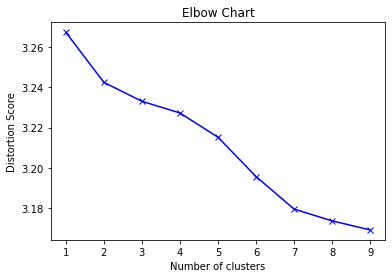

In [48]:
# we'll be testing between 1-10 clusters
distortionscores = []
K = range(1,10)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(X)
    distortionscores.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    
plt.plot(K, distortionscores, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion Score')
plt.title('Elbow Chart')
plt.show()

From the elbow analysis and the chart above, I decided to use 6 clusters

In [49]:
#from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)
# fitting our data
kmeans = kmeans.fit(X)
# prediction
labels = kmeans.predict(X)
# displaying the centroids established
centers = kmeans.cluster_centers_

In [50]:
# Append the cluster labels to the X DataFrame
X['cluster'] = kmeans.predict(X)

In [51]:
# quick view of the matrix with the corresponding cluster number
X.head()

TF_IDF                                                         \
Term -cetylpyridinium  -d3 -dayivcg -deoxy-fluoro-β-d-arabinofuranosylguanin   
Row                                                                            
0                 0.0  0.0      0.0                                      0.0   
1                 0.0  0.0      0.0                                      0.0   
2                 0.0  0.0      0.0                                      0.0   
3                 0.0  0.0      0.0                                      0.0   
4                 0.0  0.0      0.0                                      0.0   

                                                  ...                   \
Term -hour -interferon -like    a   a5 abatacept  ... zilucoplan® zinc   
Row                                               ...                    
0      0.0         0.0   0.0  0.0  0.0       0.0  ...         0.0  0.0   
1      0.0         0.0   0.0  0.0  0.0       0.0  ...         0.0  0.0   
2      0.0         0.0   0.0  0.0  0.0       0.0  ...         0.0  0.0   
3      0.0         0.0   0.0  0.0  0.0       0.0  ...         0.0  0.0   
4      0.0         0.0   0.0  0.0  0.0       0.0  ...         0.0  0.0   

                                                             cluster  
Term zithromax zotatifin zyesami™ zyil1  α1β  α2b γ-globulin          
Row                                                                   
0          0.0       0.0      0.0   0.0  0.0  0.0        0.0       5  
1          0.0       0.0      0.0   0.0  0.0  0.0        0.0       5  
2          0.0       0.0      0.0   0.0  0.0  0.0        0.0       5  
3          0.0       0.0      0.0   0.0  0.0  0.0        0.0       5  
4          0.0       0.0      0.0   0.0  0.0  0.0        0.0       5  

[5 rows x 1673 columns]

In [53]:
# TODO

# 0) Remove terms that have a low global distribution

# 1) Append the cluster information to the studies table ensure I am using the right version of the studies table 

# 2) Per cluster determine the top 5 words

# 3) Discuss results in the Notebook

# 4) Visualize this in tableu as wordcloud per cluster

